## $Finite$ $Difference$ $Method$

## $Shooting$ $Method$

### Problem-1: 

Use the Finite Difference Method and the Shooting Method to solve the boundary value problem 

$\frac{d^{2}T}{dx^{2}} + h^{'}(T_{a} − T) = 0$                                      . . . (1)

for a 10m rod with h' = 0.01$m^{−2}$ (the heat transfer coefficient), $T_{a}$ = $20^{o}C$(surrounding temperature), and the boundary conditions

T(0) = $40^{o}C$, T(10) = $200^{o}C$.

Consider atleast 10 intermediate points for your solution.


## Finite Difference Methods

In these techniques, finite divided differences are substituted for the derivatives in the original equation. 

Thus, a linear differential equation is transformed into a set of simultaneous algebraic equations that can be solved using normal methods like Gaussian Elimination, LU decomposition, etc.

The finite-divided-difference approximation for the second derivative is 

$\frac{d^{2}T}{dx^{2}} = \frac{T_{i+1} − 2T_{i} + T_{i−1}}{h^{2}}$

This approximation can be substituted into (1) to give

$\frac{T_{i+1} − 2T_{i} + T_{i−1}}{h^{2}} − h^{'}(T_{i} − T_{a}) = 0$

Collecting terms gives

$−T_{i−1} + (2 + h^{'}h^{2})T_{i} − T_{i+1} = h^{'}h^{2}T_{a}$

here, h is the step size.

This equation applies for each of the interior nodes of the rod. The first and last interior nodes, $T_{i−1}$ and $T_{i+1}$, respectively, are specified by the boundary conditions. Therefore, the resulting set of linear algebraic equations will be tridiagonal. As such, it can be solved with the efficient algorithms that are available for such systems. We use Thomas' Algorithm here.

In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [20]:
# initializing variables

h_prime = 0.01
L = 10
T_a = 20
T0 = 40
T10 = 200

In [21]:
# function which uses Thomas' Algorithm to solve tridiagonal systems

def thomas(a, b):
    n = len(a)
    
    x = np.zeros(n)
    
    # decomposition and forward substitution
    
    for i in range(n - 1):
        # decomposition
        
        a[i + 1][i] /= a[i][i]
        a[i + 1][i + 1] -= a[i + 1][i] * a[i][i + 1]
        
        # forward substitution
        
        b[i + 1] -= a[i + 1][i] * b[i]
        
    # back substitution 
    
    x[-1] = b[-1]/a[-1][-1]
    
    for i in range(n - 2, 0, -1):
        x[i] = (b[i] - (a[i - 1][i] * x[i + 1]))/a[i][i]
        
    return x 

In [22]:
# finite difference method with n intermediate points

def finite_diff(h_prime, ta, t0, t10, n, l):
    h = float(l/n)
    x = np.arange(0, l + h, step = h)
    
    # constructing matrix
    
    A = np.zeros((n, n))
    B = np.zeros(n)
    
    for i in range(n):
        A[i][i] = 2 + h_prime*(h ** 2)
    
    for i in range(n - 1):
        A[i + 1][i] = -1
        A[i][i + 1] = -1
        
    B[0] = ta * h_prime * (h**2) + t0
    B[-1] = ta * h_prime * (h**2) + t10
    
    for i in range(1, n - 1):
        B[i] = ta * h_prime * (h ** 2)
        
    #print(A)
    print("\n")
    #print(B)
    
    # solving the tridiagonal matrix using Thomas' Algorithm
     
    t = thomas(A, B)
    t[0] = t0
    
    T = np.arange(0, l + h, step = h)
    for i in range(n):
        T[i] = t[i]
        
    T[-1] = 200
    
    #print(T)
    
    return x, T, A, B

In [23]:
# plotting actual function

def exact(n):
    h = 10/n
    x = np.arange(0, 10 + h, step = h)
    T = np.arange(0, 10 + h, step = h)
    
    for i in range(n):
        T[i] = 73.4523 * math.exp(0.1 * x[i]) - 53.4523* math.exp(-0.1*x[i]) + 20
        
    T[0] = 40
    T[-1] = 200
        
    return x, T       

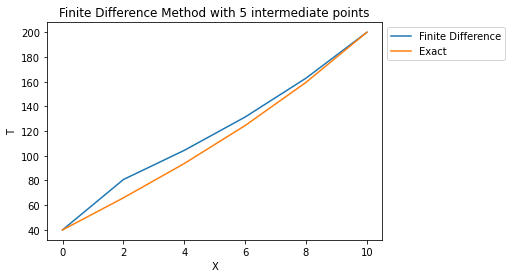

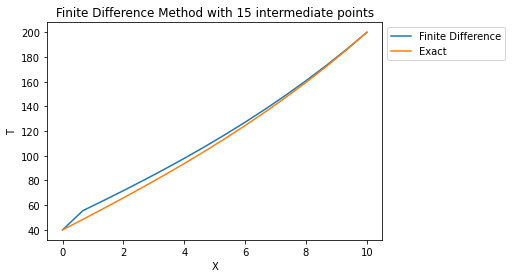

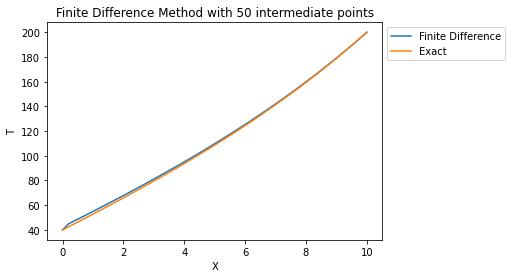

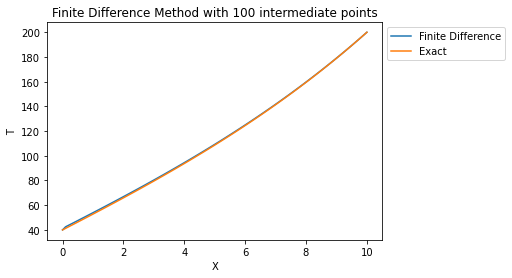

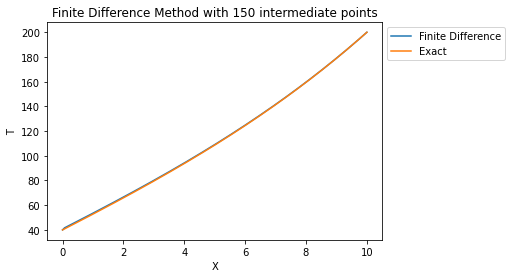

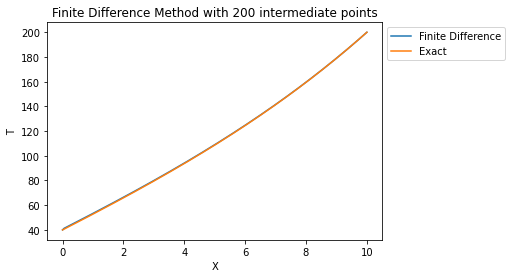

In [24]:
# plotting the curves

for n in [5, 15, 50, 100, 150, 200]:
    X_fd, T_fd, A, B = finite_diff(h_prime, T_a, T0, T10, n, L)

    X_exact, T_exact = exact(n)

    plt.plot(X_fd, T_fd, label = "Finite Difference")
    plt.plot(X_exact, T_exact, label = "Exact")
    plt.title("Finite Difference Method with " + str(n) +  " intermediate points")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

## The Shooting Method

The Shooting method is based on converting the boundary-value problem into an equivalent initial-value problem. A trial-and-error approach is then implemented to solve the initial-value version. 

The second-order equation can be expressed as two first order ODEs:

$\frac{dT}{dx} = z$ . . . (i)

$\frac{dz}{dx} = h^{'}(T − T_{a})$ . . . (ii)

To solve these equations, we require an initial value for z. For the shooting method, we guess a value—say, $z(0) = z_{0}$. The solution is then obtained by integrating (i) and (ii) simultaneously (Using RK4). 

Our aim is to find two values of z(0) -- $z0_{lesser}$ and $z0_{greater}$, such that one of the values gives $T(10, z0_{lesser}) < 200$ and the other gives $T(10, z0_{greater}) > 200$.

The coupled differential equations (i) and (ii) are linear, hence z(0) also varies linearly. Now $z0_{lesser}$ and $z0_{greater}$ can be used to compute a value of z(0) which yields T(10) = 200 by using linear interpolation : 

$z(0) = z0_{lesser} + \frac{z0_{greater} - z0_{lesser}}{T(10, z0_{greater}) - T(10, z0_{lesser})}(200 - T(10, z0_{lesser}))$




In [25]:
def f_sd(T):
    return h_prime * (T - T_a)

In [26]:
def rk_4(T_0, z_0, x_0, x_f, m):
    h = (x_f - x_0)/m
    
    x = np.zeros(m+1)
    z = np.zeros(m+1)
    T = np.zeros(m+1)
    
    z[0] = z_0
    T[0] = T_0
    
    for i in range(m):
        x[i + 1] = x[i] + h
        kx1 = z[i]
        kv1 = f_sd(T[i])
        kx2 = z[i] + (h/2.0) * kv1
        kv2 = f_sd(T[i] + kx1 * h/2.0)
        kx3 = z[i] + (h/2.0) * kv2
        kv3 = f_sd(T[i] + kx2 * h/2.0)
        kx4 = z[i] + (h) * kv3
        kv4 = f_sd(T[i] + h * kx3)
        T[i + 1] = T[i] + (kx1 + 2*kx2 + 2*kx3 + kx4) * (h/6.0)
        z[i + 1] = z[i] + (kv1 + 2*kv2 + 2*kv3 + kv4) * (h/6.0)
        
    return x, z, T

In [27]:
def shooting(m):
    # take an initial guess
    z0i = 10
    
    xi, zi, ti = rk_4(T0, z0i, 0, L, m)
        
    tfi = ti[-1]  
    print(tfi)
      
    z0f = 20
    xinew, zinew, tinew = rk_4(T0, z0f, 0, L, m)
    tff = tinew[-1]
    
    print(tff)
        
    z0_exact = z0i + (T10 - tfi)*(z0f - z0i)/(tff - tfi)
    
    x_exact, z_exact, T_exact = rk_4(T0, z0_exact, 0, L, m)
    
    return x_exact, T_exact, tinew, ti
    

168.38173204596976
285.90185139757205


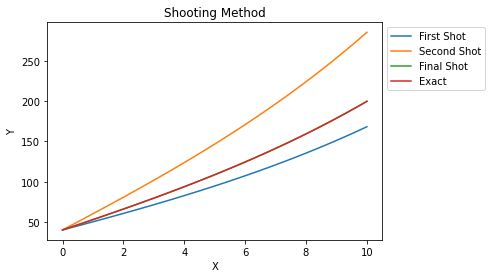

In [30]:
# plotting the curves


X_e, T_e, T_fi, T_initial = shooting(100)

plt.plot(X_e, T_initial, label = "First Shot")
plt.plot(X_e, T_fi, label = "Second Shot")
plt.plot(X_e, T_e, label = "Final Shot")
X_exact, T_exact = exact(100)
plt.plot(X_exact, T_exact, label = "Exact")
plt.legend(bbox_to_anchor = (1,1))
plt.title("Shooting Method")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()



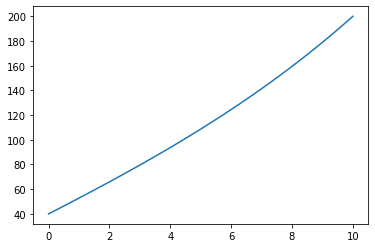

In [18]:
plt.plot(X_e, T_e, label = "Final Shot")